# SETRED
The idea of rewriting the code of the repository is to get a coomprhensive understanding of the SETRED method. 

SETRED stands for self-training with Editing. 

Create a SETRED classifier. It is a self-training algorithm that uses a rejection mechanism to avoid adding noisy samples to the training set. 

The main process are:
1. Train a classifier with the labeled data
2. Create a pool of unalbeled data and select the most confident predictions. 
3. Repeat until the maximum number of iterations is reached. 

    - a. Select the most confident predictions from the unlabeled data. 
    - b. Calculate the neighborhood graph of the labeled data and the selected instances from the unlabeled data. 
    - c. Calculate the significance level of the selected instances (Statistic J_i, sum of cut edges )
    - d. Reject the instances that are not significant according to the statistics J_i.
    - e. Add the selected instances to the labeled data and retrain the classifier. 
    - f. Add new instances to the pool of unalabeled data. 
    
4. Return the classifier trained with the labeled data. 




In [4]:
# Common libraries
import numpy as np 
import pandas as pd 
from scipy.stats import norm 
import os

# Sklearn libraries
# BaseEstimator is a helper class provided by scikit-learn to make it easier to create your own custom models or transformers that behave like 
# any other scikit-learn model. 
# MetaEstimatorMixin is a mixin class from sksklearn.base to help create meta-estimators, which are estimators that wrap other estimators.
from sklearn.base import BaseEstimator, MetaEstimatorMixin, ClassifierMixin
# The clone function creates a new copy of an estimator with the same parameters, but without any trained data, without any fitted attributes. 
from sklearn.base import clone as skclone 
from sklearn.base import is_classifier
from sklearn.ensemble._base import _set_random_states

# Models
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.semi_supervised import SelfTrainingClassifier

# Utils
from sklearn.utils import check_random_state, resample
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.metaestimators import available_if

# Selection classifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    log_loss)

from sklearn.metrics import classification_report

# Simulation functions
from sklearn.datasets import make_classification, make_blobs
from adspy_shared_utilities import plot_class_regions_for_classifier

# Visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

# Data
from sklearn.datasets import load_iris

# SSlearn library
from sslearn.utils import calculate_prior_probability, check_classifier
from sslearn.model_selection import artificial_ssl_dataset
from sslearn.wrapper import Setred

In [2]:
from setred_package import Setred_scratch, simulated_data

# Simulation

The simulation consists of:

- n: 13000 intances
- classes: 5 labels
- X: design matrix

In [6]:
X = np.load("data/X.npy")
y = np.load("data/y.npy")
X_unlabel = np.load("data/X_unlabel.npy")
y_unlabel = np.load("data/y_unlabel.npy")
X_ori = np.load("data/X_ori.npy")
y_ori = np.load("data/y_ori.npy")


In [42]:
cmap_bold = ListedColormap(colors = [
    '#FF0000',  # Red
    '#00FF00',  # Lime Green
    '#0000FF',  # Blue
    '#800080',  # Purple
    '#00FFFF',  # Cyan / Aqua
    '#FFC0CB',  # Pink
    '#808080',  # Gray
    '#A52A2A',  # Brown
])

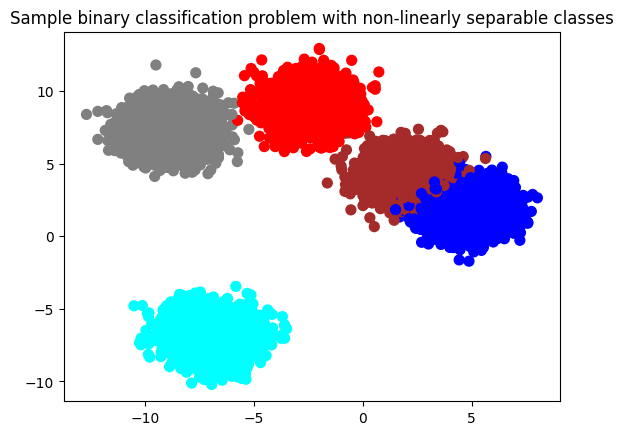

In [43]:
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_ori[:,0], X_ori[:,1], c=y_ori,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

## Generation of artificial semisupervised learning


In [45]:
# Print the shape of the datasets
print(f"Shape of X: {X.shape}, y: {y.shape}, X_unlabel: {X_unlabel.shape}, y_unlabel: {y_unlabel.shape}")
# Print the number of the classes in y
print(f"Frequencies of classes in y: {pd.Series(y).value_counts(normalize=False)}")


Shape of X: (13000, 2), y: (13000,), X_unlabel: (12870, 2), y_unlabel: (12870,)
Frequencies of classes in y: -1    12870
 0       39
 4       28
 1       23
 3       21
 2       19
Name: count, dtype: int64


In [46]:
# Filtering the labeled instances
X_label = X[y != -1]
y_label = y[y != -1]
# Spliting the dataset into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_label, y_label, test_size=0.5, random_state=42, stratify=y_label)
# Print the shape of the validation and testing sets
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
# Print the number of the classes in y_val and y_test
print(f"Frequencies of classes in y_val: {pd.Series(y_val).value_counts(normalize=False)}")
print(f"Frequencies of classes in y_test: {pd.Series(y_test).value_counts(normalize=False)}")


Shape of X_val: (65, 2), y_val: (65,), X_test: (65, 2), y_test: (65,)
Frequencies of classes in y_val: 0    19
4    14
1    12
3    11
2     9
Name: count, dtype: int64
Frequencies of classes in y_test: 0    20
4    14
1    11
2    10
3    10
Name: count, dtype: int64


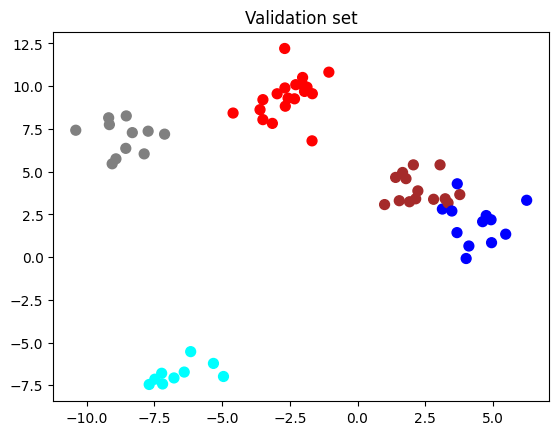

In [47]:
plt.figure()
plt.title('Validation set')
plt.scatter(X_val[:,0], X_val[:,1], c=y_val,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

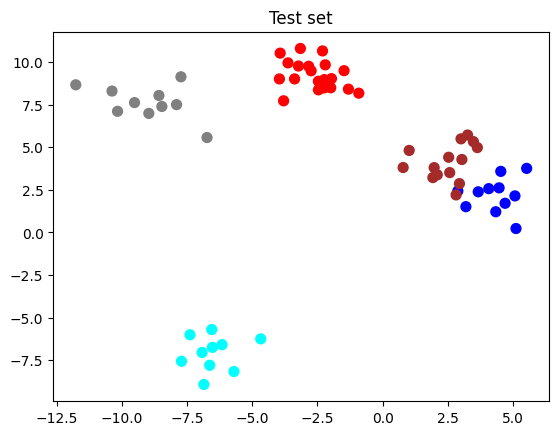

In [49]:
plt.figure()
plt.title('Test set')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

# Decision Tree

- Hyperparamter tunning with the validation data
- Check the performance of the classifier on the test data

In [ ]:
# Fitting a decision tree with hyperparameters tunning using cross validation
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(dt, param_grid, cv=5)
print("The shape of X_val:", X_val.shape)
print("The shape of y_val:", y_val.shape)

grid_search.fit(X_val, y_val)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Base estimator
base_estimator_dt = DecisionTreeClassifier(**best_params, random_state=42)

In [ ]:
# Fit the base estimator on the validation set
dt_fitted = base_estimator_dt.fit(X_val, y_val)

In [ ]:
# Print the accuracy of the base estimator on the validation set
y_val_pred = base_estimator_dt.predict(X_val)
y_test_pred = base_estimator_dt.predict(X_test)
# Print the accuracy of the base estimator on the validation set
print(f"Accuracy of the base estimator on the validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy of the base estimator on the test set: {accuracy_score(y_test, y_test_pred)}")
# Classification report
from sklearn.metrics import classification_report
print("Classification report on validation set:")
print(classification_report(y_val, y_val_pred))
print("Classification report on test set:")
print(classification_report(y_test, y_test_pred))

In [ ]:
# Predict the instances that are not labeled with the base estimator
y_unlabel_pred = base_estimator_dt.predict(X_unlabel)
# Print the accuracy of the base estimator on the unlabeled set
print(f"Accuracy of the base estimator on the unlabeled set: {accuracy_score(y_unlabel, y_unlabel_pred)}")
# Print the classification report on the unlabeled set
print("Classification report on unlabeled set:")
print(classification_report(y_unlabel, y_unlabel_pred))


# SETRED CLASSIFIER

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Decision Tree

In [ ]:

# Fitting the Setred classifier
ssl_clf_dt = Setred_scratch(base_estimator=base_estimator_dt,
                         max_iterations=60,
                         graph_neighbors=100,                        
                         htunning=True,
                         param_grid={
                                'max_depth': [None, 5, 10, 15],
                                'min_samples_split': [2, 5, 10],
                                'min_samples_leaf': [1, 2, 4]
                            },
                        X_label_real=X_unlabel,
                        y_label_real=y_unlabel,
                        view = 10)
ssl_clf_dt.fit(X, y)
